**Conectando ao Google Drive para extrair os arquivos**

# Tarefa 1 – Preparação dos Dados



In [ ]:
# 1.1 – Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# 1.2 – Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# 1.3 – Definindo o caminho da pasta do Google Drive
path = '/content/drive/MyDrive/olist-dataset/'

# Carregando os arquivos CSV
orders = pd.read_csv(path + 'olist_orders_dataset.csv')
customers = pd.read_csv(path + 'olist_customers_dataset.csv')
order_items = pd.read_csv(path + 'olist_order_items_dataset.csv')
products = pd.read_csv(path + 'olist_products_dataset.csv')
sellers = pd.read_csv(path + 'olist_sellers_dataset.csv')
geolocation = pd.read_csv(path + 'olist_geolocation_dataset.csv')
order_payments = pd.read_csv(path + 'olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(path + 'olist_order_reviews_dataset.csv')
category_translation = pd.read_csv(path + 'product_category_name_translation.csv')


In [ ]:
# 1.4 – Verificação inicial dos dados
orders.info()
orders.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [ ]:
# 1.5 – Conversão de colunas de data
date_cols = ['order_purchase_timestamp', 'order_approved_at',
             'order_delivered_carrier_date', 'order_delivered_customer_date',
             'order_estimated_delivery_date']

for col in date_cols:
    orders[col] = pd.to_datetime(orders[col])

# Remove registros sem data de entrega (opcional, dependendo da análise futura)
orders = orders[orders['order_delivered_customer_date'].notnull()]


In [ ]:
# 1.6 – Mescla nomes traduzidos às categorias de produtos
products = products.merge(category_translation, on='product_category_name', how='left')


In [ ]:
# 1.7 – Verificar duplicatas
print("Duplicatas em orders:", orders.duplicated().sum())


Duplicatas em orders: 0


In [ ]:
# 1.8 – Construção de uma base integrada
df_full = orders.merge(customers, on='customer_id', how='left') \
                .merge(order_payments, on='order_id', how='left') \
                .merge(order_reviews, on='order_id', how='left')

df_full.head()


# Tarefa 2 – Análise Exploratória de Dados


In [ ]:
# Importando as bibliotecas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# a) Qual o volume de pedidos por mês? Existe sazonalidade nas vendas?

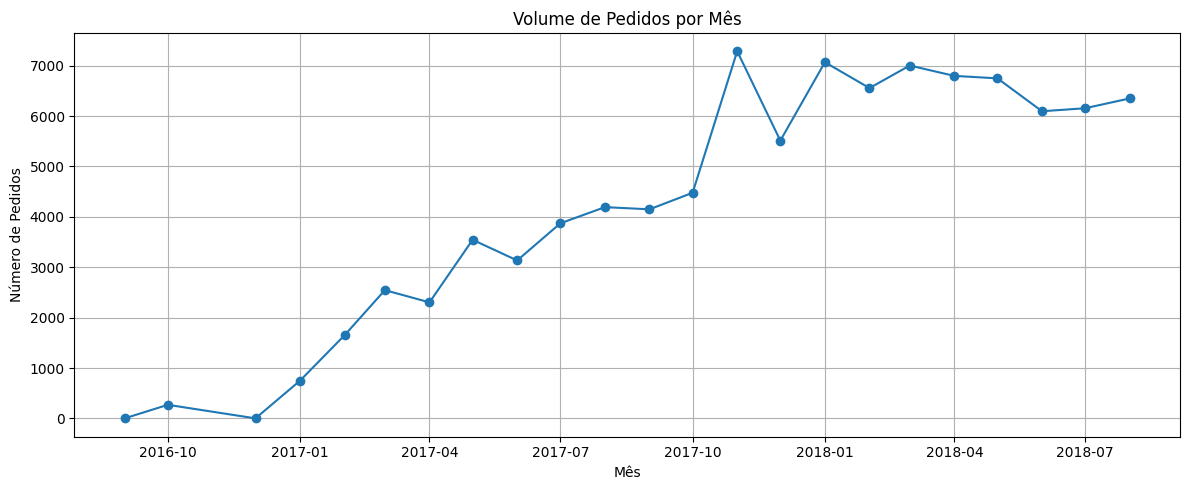

In [ ]:
# Criando a coluna de ano-mês
orders['order_month'] = orders['order_purchase_timestamp'].dt.to_period('M')

# Contar o número de pedidos únicos por mês
orders_by_month = orders.groupby('order_month')['order_id'].nunique().reset_index()
orders_by_month['order_month'] = orders_by_month['order_month'].dt.to_timestamp()

# Visualização
plt.figure(figsize=(12, 5))
plt.plot(orders_by_month['order_month'], orders_by_month['order_id'], marker='o')
plt.title('Volume de Pedidos por Mês')
plt.xlabel('Mês')
plt.ylabel('Número de Pedidos')
plt.grid(True)
plt.tight_layout()
plt.show()


# b) Qual a distribuição do tempo de entrega dos pedidos?

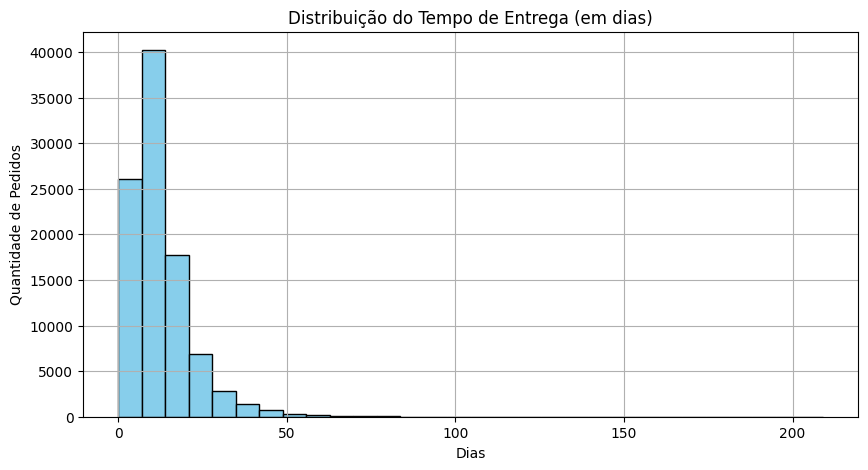

In [ ]:
# Tempo de entrega em dias
orders['delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

# Histograma
plt.figure(figsize=(10,5))
plt.hist(orders['delivery_time'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuição do Tempo de Entrega (em dias)')
plt.xlabel('Dias')
plt.ylabel('Quantidade de Pedidos')
plt.grid(True)
plt.show()


# c) Qual a relação entre o valor do frete e a distância de entrega?

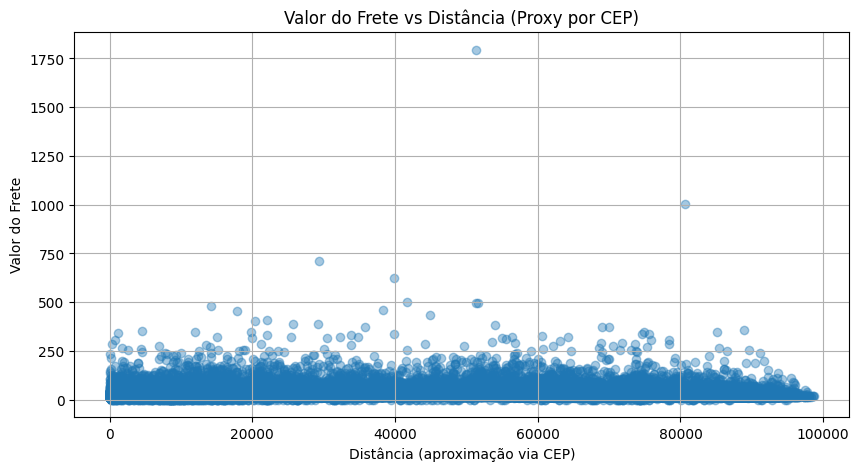

In [ ]:
# Mesclando(merge) para pegar seller_zip e customer_zip
merged = orders.merge(customers, on='customer_id') \
               .merge(order_items, on='order_id') \
               .merge(sellers, on='seller_id')

# Agrupamento por pedido
frete_dist = merged.groupby('order_id').agg({
    'freight_value': 'sum',
    'customer_zip_code_prefix': 'first',
    'seller_zip_code_prefix': 'first'
}).reset_index()

# Criando distância aproximada (proxy)
frete_dist['distance_proxy'] = abs(frete_dist['customer_zip_code_prefix'] - frete_dist['seller_zip_code_prefix'])

# Scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(frete_dist['distance_proxy'], frete_dist['freight_value'], alpha=0.4)
plt.title('Valor do Frete vs Distância (Proxy por CEP)')
plt.xlabel('Distância (aproximação via CEP)')
plt.ylabel('Valor do Frete')
plt.grid(True)
plt.show()


# d) Quais são as categorias de produtos mais vendidas em termos de faturamento?

In [ ]:
# Juntando categorias traduzidas
order_items_cat = order_items.merge(products, on='product_id') \
                             .merge(category_translation, on='product_category_name', how='left')

# Faturamento por categoria
faturamento = order_items_cat.groupby('product_category_name_english')['price'].sum().sort_values(ascending=False).head(10)

# Gráfico de barras
faturamento.plot(kind='bar', figsize=(12,5), title='Top 10 Categorias por Faturamento',
                 xlabel='Categoria', ylabel='Faturamento (R$)', color='coral', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'product_category_name_english'

# e) Quais estados brasileiros possuem o maior valor médio de pedido?

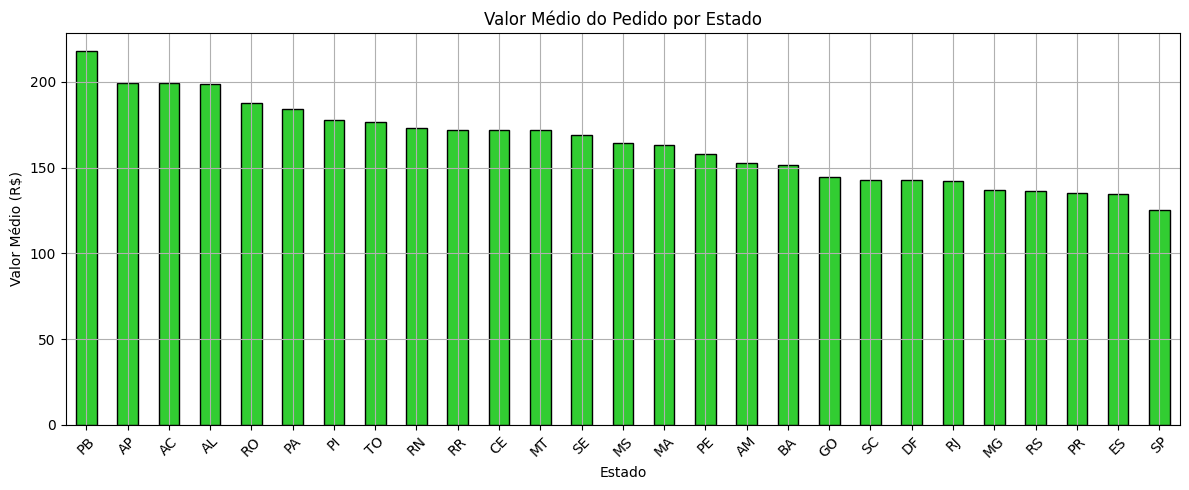

In [ ]:
# Juntar pedidos com estados e valores
order_state = orders.merge(customers, on='customer_id') \
                    .merge(order_items.groupby('order_id')['price'].sum().reset_index(), on='order_id')

# Valor médio por estado
media_por_estado = order_state.groupby('customer_state')['price'].mean().sort_values(ascending=False)

# Plotagem
media_por_estado.plot(kind='bar', figsize=(12,5), title='Valor Médio do Pedido por Estado',
                      xlabel='Estado', ylabel='Valor Médio (R$)', color='limegreen', edgecolor='black')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# Tarefa 3 – Soluções de Problemas de Negócio

Taxa de clientes recorrentes: 0.00%


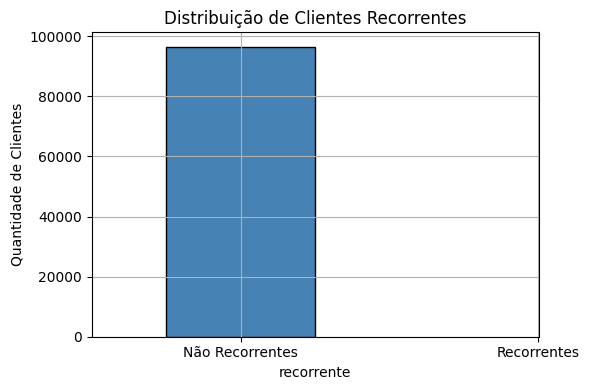

In [15]:
# Contar quantos pedidos cada cliente fez
cliente_pedidos = orders.groupby('customer_id')['order_id'].nunique().reset_index()

# Classificar como recorrente se > 1 pedido
cliente_pedidos['recorrente'] = cliente_pedidos['order_id'] > 1

# Calcular a taxa de recorrência
taxa_recorrente = cliente_pedidos['recorrente'].mean()
print(f'Taxa de clientes recorrentes: {taxa_recorrente:.2%}')

# Visualizar distribuição
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
cliente_pedidos['recorrente'].value_counts().plot(kind='bar', color='steelblue', edgecolor='black')
plt.xticks([0,1], ['Não Recorrentes', 'Recorrentes'], rotation=0)
plt.title('Distribuição de Clientes Recorrentes')
plt.ylabel('Quantidade de Clientes')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Criar variável target: 1 se houve atraso, 0 caso contrário
orders['atrasado'] = orders['order_delivered_customer_date'] > orders['order_estimated_delivery_date']
orders['atrasado'] = orders['atrasado'].astype(int)

# Features: tempo até aprovação e até envio
orders['tempo_aprovacao'] = (orders['order_approved_at'] - orders['order_purchase_timestamp']).dt.total_seconds() / 3600
orders['tempo_envio'] = (orders['order_delivered_carrier_date'] - orders['order_approved_at']).dt.total_seconds() / 3600

# Dataset final para modelagem
df_model = orders[['tempo_aprovacao', 'tempo_envio', 'atrasado']].dropna()

X = df_model[['tempo_aprovacao', 'tempo_envio']]
y = df_model['atrasado']

# Treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Avaliação
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.99      0.95     26607
           1       0.29      0.06      0.10      2332

    accuracy                           0.91     28939
   macro avg       0.61      0.52      0.53     28939
weighted avg       0.87      0.91      0.89     28939



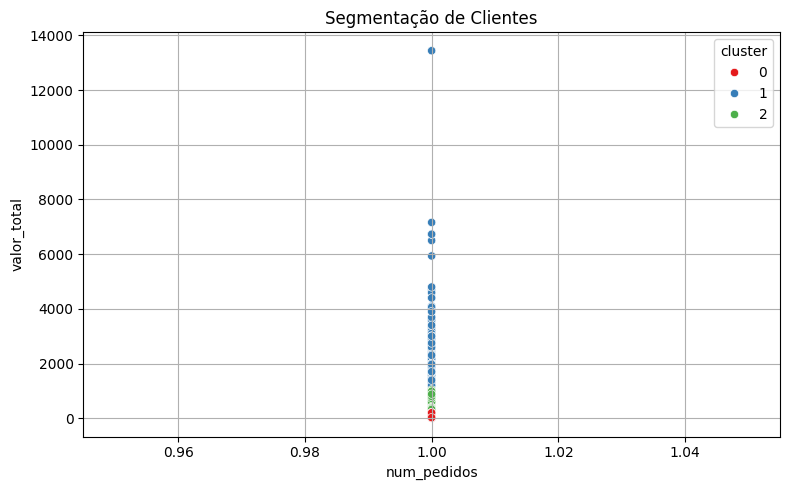

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Agrupar clientes por nº de pedidos e valor total
clientes = orders.merge(order_items, on='order_id')
clientes_agg = clientes.groupby('customer_id').agg({
    'order_id': 'nunique',
    'price': 'sum'
}).rename(columns={'order_id': 'num_pedidos', 'price': 'valor_total'})

# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clientes_agg)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clientes_agg['cluster'] = kmeans.fit_predict(X_scaled)

# Visualizar clusters
plt.figure(figsize=(8,5))
sns.scatterplot(data=clientes_agg, x='num_pedidos', y='valor_total', hue='cluster', palette='Set1')
plt.title('Segmentação de Clientes')
plt.grid(True)
plt.tight_layout()
plt.show()


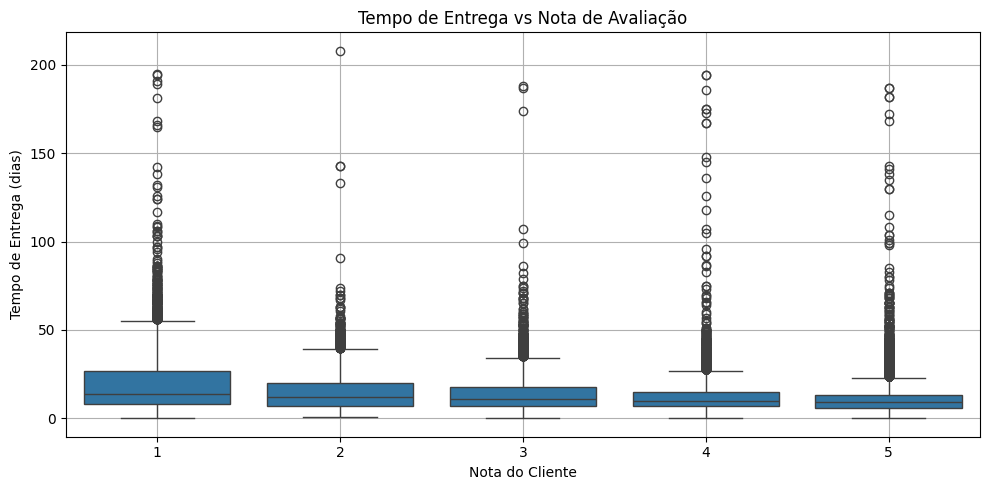

In [18]:
# Unir avaliações com categorias e tempo de entrega
avaliacoes = order_reviews.merge(orders[['order_id', 'delivery_time']], on='order_id', how='left') \
                          .merge(order_items[['order_id', 'product_id']], on='order_id') \
                          .merge(products[['product_id', 'product_category_name']], on='product_id', how='left') \
                          .merge(category_translation, on='product_category_name', how='left')

# Visualizar tempo de entrega por nota
plt.figure(figsize=(10,5))
sns.boxplot(data=avaliacoes, x='review_score', y='delivery_time')
plt.title('Tempo de Entrega vs Nota de Avaliação')
plt.xlabel('Nota do Cliente')
plt.ylabel('Tempo de Entrega (dias)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Tarefa 4 – Visualizações e Dashboards

In [19]:
import plotly.express as px

# Adiciona colunas úteis
orders['order_month'] = orders['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()

# Juntando com categoria e estado
df_vendas = orders.merge(customers[['customer_id', 'customer_state']], on='customer_id') \
                  .merge(order_items[['order_id', 'product_id', 'price']], on='order_id') \
                  .merge(products[['product_id', 'product_category_name']], on='product_id') \
                  .merge(category_translation, on='product_category_name', how='left')

# Agrupando vendas por mês, estado e categoria
vendas_agrupadas = df_vendas.groupby(['order_month', 'customer_state', 'product_category_name_english'])['price'].sum().reset_index()

# Gráfico interativo
fig = px.line(vendas_agrupadas, x='order_month', y='price', color='product_category_name_english',
              facet_col='customer_state', facet_col_wrap=4,
              title='Evolução das Vendas por Estado e Categoria',
              labels={'price': 'Faturamento (R$)', 'order_month': 'Mês'})
fig.update_layout(height=900)
fig.show()


In [20]:
# Agrupamento por estado
vendas_estado = df_vendas.groupby('customer_state')['price'].sum().reset_index()

# Gráfico tipo choropleth
fig = px.choropleth(locations=vendas_estado['customer_state'],
                    locationmode="ISO-3166-2",
                    geojson="https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson",
                    color=vendas_estado['price'],
                    hover_name=vendas_estado['customer_state'],
                    color_continuous_scale="YlOrRd",
                    title="Faturamento Total por Estado")
fig.update_geos(fitbounds="locations", visible=False)
fig.show()


ValueError: 
    Invalid value of type 'builtins.str' received for the 'locationmode' property of choropleth
        Received value: 'ISO-3166-2'

    The 'locationmode' property is an enumeration that may be specified as:
      - One of the following enumeration values:
            ['ISO-3', 'USA-states', 'country names', 'geojson-id']

In [21]:
# Gráfico interativo de dispersão
fig = px.box(avaliacoes, x='review_score', y='delivery_time',
             title='Tempo de Entrega por Nota de Avaliação do Cliente',
             labels={'review_score': 'Nota', 'delivery_time': 'Tempo de Entrega (dias)'})
fig.show()


In [22]:
# Juntar seller_id com notas e tempos de entrega
vendedor_df = order_items.merge(orders[['order_id', 'order_delivered_customer_date', 'order_purchase_timestamp']], on='order_id') \
                         .merge(order_reviews[['order_id', 'review_score']], on='order_id', how='left')

vendedor_df['tempo_entrega'] = (vendedor_df['order_delivered_customer_date'] - vendedor_df['order_purchase_timestamp']).dt.days

# Métricas por vendedor
vendedor_metrics = vendedor_df.groupby('seller_id').agg({
    'order_id': 'nunique',
    'review_score': 'mean',
    'tempo_entrega': 'mean'
}).reset_index().rename(columns={'order_id': 'total_pedidos',
                                 'review_score': 'avaliacao_media',
                                 'tempo_entrega': 'entrega_media'})

# Top 20 vendedores com mais pedidos
top_vendedores = vendedor_metrics.sort_values('total_pedidos', ascending=False).head(20)

# Gráfico de barras múltiplas
fig = px.bar(top_vendedores, x='seller_id', y='total_pedidos',
             hover_data=['avaliacao_media', 'entrega_media'],
             title='Top 20 Vendedores: Volume, Avaliação e Entrega',
             labels={'total_pedidos': 'Total de Pedidos', 'seller_id': 'Vendedor'})
fig.show()
